## load back the results from apeglm and add the old stats that were generated

In [7]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from functools import partial
import glob
import os
import math
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import io
import pickle
import pybedtools as pbed
import vcf
from functools import reduce
plt.rcParams['svg.fonttype'] = 'none'
base_dir = "http://bartzabel.ls.manchester.ac.uk/orozcolab/SNP2Mechanism/"

In [8]:
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col=0)

In [9]:
CD4_apeglm_results = pd.read_csv(".local/hic_goingtoR/apeglm_results_CD4.txt", index_col=0)
CD8_apeglm_results = pd.read_csv(".local/hic_goingtoR/apeglm_results_CD8.txt", index_col=0)
ALL_apeglm_results = pd.read_csv(".local/hic_goingtoR/apeglm_results_ALL.txt", index_col=0)

In [10]:
CD4_rownames = pd.read_csv(".local/hic_goingtoR/hic_CD4_allele_counts.csv", index_col=0)
CD8_rownames = pd.read_csv(".local/hic_goingtoR/hic_CD8_allele_counts.csv", index_col=0)
ALL_rownames = pd.read_csv(".local/hic_goingtoR/hic_ALL_allele_counts.csv", index_col=0)

In [11]:
CD4_rownames["svalue"] = CD4_apeglm_results["x"].to_list()
CD8_rownames["svalue"] = CD8_apeglm_results["x"].to_list()
ALL_rownames["svalue"] = ALL_apeglm_results["x"].to_list()

In [12]:
CD4_apeglm_results = CD4_rownames
CD8_apeglm_results = CD8_rownames
ALL_apeglm_results = ALL_rownames

In [17]:
var_matcher = {}
for chrom in range(1,23):
    vcf_f = pbed.BedTool(f"../.local/called_genotypes/HAPCUT_phased_merged_chr{chrom}_annotated_filtered.vcf.gz")
    loop_anchors = pbed.BedTool("loop_anchors_merged.bed")
    filtered_vcf = vcf_f.intersect(loop_anchors,u = True, header = True)

    variants = vcf.Reader(filename=filtered_vcf.fn)

    for record in variants:
        var_matcher[record.ID] = record.POS

In [18]:
CD4_apeglm_results_significant = CD4_apeglm_results[CD4_apeglm_results["svalue"] < 0.10]
CD8_apeglm_results_significant = CD8_apeglm_results[CD8_apeglm_results["svalue"] < 0.10]
ALL_apeglm_results_significant = ALL_apeglm_results[ALL_apeglm_results["svalue"] < 0.10]

In [19]:
loops_CD4 = pd.read_csv(".local/output_counts/NRHV014XCD4_ARIMA.bedpe", sep="\t", header=None)[[0,1,2,3,4,5,6,7]]
loops_CD8 = pd.read_csv(".local/output_counts/NRHV014XCD8_ARIMA.bedpe", sep="\t", header=None)[[0,1,2,3,4,5,6,7]]

In [20]:
output_dataframe_CD4 = pd.DataFrame(columns = "chrA startA endA chrB startB endB loopID loopScore rsID rsCoord REF_counts ALT_counts svalue".split())
for key, x in CD4_apeglm_results_significant.iterrows():
    rsID, loopID = key.split("_")
    loop = loops_CD4.iloc[int(loopID)]
    output_dataframe_CD4.loc[key] = [loop[0],loop[1],loop[2],loop[3],loop[4],loop[5],loopID,loop[6],rsID, var_matcher[rsID], x["REF_counts"], x["ALT_counts"], x["svalue"]]
output_dataframe_CD4.to_csv(".local/results/allelic_imbalance_CD4_apeglm_results.csv")

In [21]:
output_dataframe_CD8 = pd.DataFrame(columns = "chrA startA endA chrB startB endB loopID loopScore rsID rsCoord REF_counts ALT_counts svalue".split())
for key, x in CD8_apeglm_results_significant.iterrows():
    rsID, loopID = key.split("_")
    loop = loops_CD8.iloc[int(loopID)]
    output_dataframe_CD8.loc[key] = [loop[0],loop[1],loop[2],loop[3],loop[4],loop[5],loopID,loop[6],rsID, var_matcher[rsID], x["REF_counts"], x["ALT_counts"], x["svalue"]]
output_dataframe_CD8.to_csv(".local/results/allelic_imbalance_CD8_apeglm_results.csv")


In [22]:
output_dataframe_ALL = pd.DataFrame(columns = "chrA startA endA chrB startB endB loopID loopScore rsID rsCoord REF_counts ALT_counts svalue".split())
for key, x in ALL_apeglm_results_significant.iterrows():
    rsID, loopID = key.split("_")
    loop = loops_CD4.iloc[int(loopID)]
    output_dataframe_ALL.loc[key] = [loop[0],loop[1],loop[2],loop[3],loop[4],loop[5],loopID,loop[6],rsID, var_matcher[rsID], x["REF_counts"], x["ALT_counts"], x["svalue"]]
output_dataframe_ALL.to_csv(".local/results/allelic_imbalance_ALL_apeglm_results.csv")

## make venn diagram of results

In [23]:
output_dataframe_CD4 = pd.read_csv(".local/results/allelic_imbalance_CD4_apeglm_results.csv", index_col=0)
output_dataframe_CD8 = pd.read_csv(".local/results/allelic_imbalance_CD8_apeglm_results.csv", index_col=0)
output_dataframe_ALL = pd.read_csv(".local/results/allelic_imbalance_ALL_apeglm_results.csv", index_col=0)

In [24]:
loops_CD8

,0,1,2,3,4,5,6,7
0,chr1,3900000,3905000,chr1,5387500,5390000,5.564770e-03,2.111213
1,chr1,3910000,3912500,chr1,5447500,5450000,3.198543e-03,2.111213
2,chr1,3910000,3912500,chr1,5480000,5482500,2.420484e-04,2.111213
3,chr1,3910000,3912500,chr1,5510000,5512500,3.859064e-04,2.111213
4,chr1,3910000,3912500,chr1,5742500,5745000,6.000093e-09,2.111213
...,...,...,...,...,...,...,...,...
106157,chrY,21172500,21175000,chrY,21257500,21260000,7.689203e-03,2.111213
106158,chrY,21182500,21185000,chrY,21255000,21257500,1.268614e-02,3.675835
106159,chrY,21187500,21190000,chrY,21250000,21252500,1.376789e-02,2.111213
106160,chrY,21190000,21192500,chrY,21230000,21232500,2.364235e-02,3.200000


In [30]:
len(set(output_dataframe_ALL["loopID"].to_list() + output_dataframe_CD8["loopID"].to_list() + output_dataframe_CD4["loopID"].to_list()))


1132

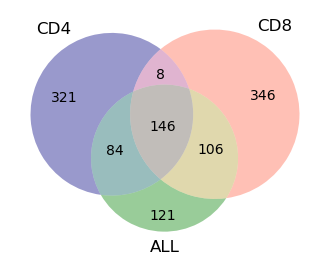

In [26]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Define the sets
set1 = set(output_dataframe_CD4["loopID"].to_list())
set2 = set(output_dataframe_CD8["loopID"].to_list())
set3 = set(output_dataframe_ALL["loopID"].to_list())

fig, ax = plt.subplots(1,1,figsize=(4,4))
# Create the Venn diagram
v = venn3([set1, set2, set3], set_colors=["navy","tomato", "green"],set_labels=('CD4', 'CD8', "ALL"), ax=ax)

# Show the plot
fig.savefig(f"figures/loops_allele_associated.svg", dpi = 600)